In [2]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
from google.colab import output
solvers.options['show_progress'] = False

In [3]:
def mean_variance_model_cvxopt(asset_prices, R, S):
  S = int(S)
  S = max(S,1)
  S = min(S,50)
  if (S==1):
    ww = np.zeros(len(asset_prices[0]))
    ww[0] = 1
    return 1000000, ww
  temparr = asset_prices[:,:S]
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  exp_return = np.mean(return_rate,axis=0)
  temp_cov = np.cov(np.transpose(return_rate))
  num_companies = S

  temp_cov += np.eye(num_companies) * 1e-6
  e = np.ones(num_companies)

  P = matrix(2*temp_cov)
  q = matrix(np.zeros(num_companies))

  A = matrix(np.array([e, exp_return]))
  b = matrix(np.array([1,R]))

  G = matrix(-np.eye(num_companies))
  h = matrix(np.zeros(num_companies))
  sol = solvers.qp(P, q, G=G, h=h, A=A, b=b)

  wmw = np.array(sol['x'])
  wmw = wmw/sum(wmw)

  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)

  ww = np.zeros(len(asset_prices[0]))
  ww[:S] = wmw.flatten()

  return mkw_risk, ww

In [4]:
def lowerLevelSolutionArray(ogarr, candidate_returns, candidate_number_of_assets):

  n = len(candidate_returns)
  minRisks = []
  # minRiskWeights = []

  for ind in range(n):
    solInd, ww = mean_variance_model_cvxopt(ogarr,candidate_returns[ind],candidate_number_of_assets[ind])
    minRisks.append(solInd)
    # minRiskWeights.append(ww)

  return np.array(minRisks)

In [5]:
def calculate_returns(prices):
  """Calculate daily returns from prices."""
  return (prices[:-1] - prices[1:]) / prices[1:]

def calculate_portfolio_returns(returns, weights):
  """Calculate portfolio returns given asset returns and weights."""
  # print(returns.shape)
  # print(weights.shape)
  # print(weights)
  return np.dot(returns, weights)

def calculate_moments(returns):
  """Calculate the first four moments of returns."""
  n = len(returns)
  mean = np.sum(returns) / n
  variance = np.sum((returns - mean) ** 2) / n
  skewness = np.sum((returns - mean) ** 3) / (n * variance ** 1.5)
  kurtosis = np.sum((returns - mean) ** 4) / (n * variance ** 2)
  return mean, variance, skewness, kurtosis

def calculate_skewness_kurtosis(weights, prices):
  # Calculate returns for each asset
  asset_returns = np.apply_along_axis(calculate_returns, 0, prices)

  # Calculate portfolio returns
  portfolio_returns = calculate_portfolio_returns(asset_returns, weights)

  # Calculate moments
  mean, var, portfolio_skewness, portfolio_kurtosis = calculate_moments(portfolio_returns)

  return mean/((var)**(0.5)), portfolio_skewness, portfolio_kurtosis


In [ ]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=7af533b69fa50ae29bcb4876734462bd3b4607b66152f20b67ed2e9c83cd039e
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [ ]:
import pymoo
print("pymoo installed successfully!")

pymoo installed successfully!


In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

NSGA Model for Multiobjective solution

In [ ]:
class PortfolioProblem(Problem):
  def __init__(self, asset_prices):
    super().__init__(n_var=2,  # Number of variables (R, S)
                      n_obj=3,  # Number of objectives (SR, Skew, -Kurt)
                      n_constr=0,  # Number of constraints
                      xl=[0, 5],  # Lower bounds for variables
                      xu=[2, 50])  # Upper bounds for variables
    self.asset_prices = asset_prices

  def _evaluate(self, x, out, *args, **kwargs):
    # Calculate SR, Skew, and -Kurt based on x (R, S)
    # For simplicity, assume these are calculated functions

    srArray = []
    skewArray = []
    kurtArray = []

    for ind in range(len(x)):
      risk, weights = mean_variance_model_cvxopt(self.asset_prices, x[ind][0], x[ind][1])
      sr, skew, kurt = calculate_skewness_kurtosis(weights, self.asset_prices)

      srArray.append(sr)
      skewArray.append(skew)
      kurtArray.append(-kurt)

    srArray = np.array(srArray)
    skewArray = np.array(skewArray)
    kurtArray = np.array(kurtArray)

    out["F"] = np.array([-srArray, -skewArray, -kurtArray]).T

Data Collection

In [6]:
pricesDF = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')
pricesDF = pricesDF[pricesDF.columns[1:]]

pricesNP = pricesDF.to_numpy()
return_rate = (pricesNP[:-1] - pricesNP[1:])/pricesNP[1:]
exp_return = np.mean(return_rate,axis=0)

sorted_indices = np.argsort(exp_return)
sorted_pricesNP = pricesNP[:, sorted_indices]

In [7]:
window = 30
num_days = len(pricesDF.index)
num_companies = pricesDF.columns.size
total_rows = num_days - window # Modified(decreased by 1) as we are checking with actual returns

In [8]:
pareto_returns = []
pareto_constraints = []

Applying algorithm

In [ ]:
for i in range(total_rows):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_variance = np.var(temp_return_rate, axis=0)

  # Sort indices by increasing order of variance
  temp_sorted_indices = np.argsort(temp_variance)

  # Reorder columns of prices array by sorted variance
  temp_sorted_price_np = temp_price_np[:, temp_sorted_indices]

  problem = PortfolioProblem(temp_sorted_price_np)
  algorithm = NSGA2(pop_size=40)
  result = minimize(problem, algorithm, ('n_gen', 100), seed=1, verbose=False)

  pareto_returns.append(result.X[:, 0])
  pareto_constraints.append(result.X[:, 1])

<ipython-input-2-41103a03aaa1>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)


In [ ]:
pareto_returns_np = np.array(pareto_returns)
pareto_constraints_np = np.array(pareto_constraints)

pareto_returns_df = pd.DataFrame(pareto_returns_np)
pareto_constraints_df = pd.DataFrame(pareto_constraints_np)

pareto_returns_df.to_csv('pareto_returns.csv', index=False)
pareto_constraints_df.to_csv('pareto_constraints.csv', index=False)

###Comparison with MOPSO:
Calculations for MOPSO
- Average actual returns
- Average objective functions: Sharpe, Skewness, Kurtosis

Calculations for NSGA
- For each pareto front
  - Calculate max, avg and min of objective functions
  - Max, min and avg of actual returns
- Calculate average of each of above calculations

In [9]:
weights_mopso_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/weights_mo_pso_bilevel_convex_combination.csv')
weights_mopso_bilevel = weights_mopso_bilevel_df.to_numpy()
weights_mopso_bilevel = weights_mopso_bilevel[1:]

returns_nsga_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/pareto_returns.csv')
returns_nsga_bilevel = returns_nsga_bilevel_df.to_numpy()
returns_nsga_bilevel = returns_nsga_bilevel[1:]

constraints_nsga_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/pareto_constraints.csv')
constraints_nsga_bilevel = constraints_nsga_bilevel_df.to_numpy()
returns_nsga_bilevel = returns_nsga_bilevel[1:]

In [27]:
weights_nsga_bilevel = []
for day in range(len(returns_nsga_bilevel)):
  weights_day = []

  for ind in range(len(returns_nsga_bilevel[day])):
    _, ww = mean_variance_model_cvxopt(sorted_pricesNP, returns_nsga_bilevel[day][ind], constraints_nsga_bilevel[day][ind])
    weights_day.append(ww)

  weights_nsga_bilevel.append(weights_day)

weights_nsga_bilevel = np.array(weights_nsga_bilevel)

<ipython-input-3-41103a03aaa1>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)


In [28]:
for i in range(1, total_rows-1):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_variance = np.var(temp_return_rate, axis=0)

  # Sort indices by increasing order of variance
  temp_sorted_indices = np.argsort(temp_variance)

  # Reorder columns of prices array by sorted variance
  temp_sorted_price_np = temp_price_np[:, temp_sorted_indices]

  for ind in range(len(weights_nsga_bilevel[i-1])):

    # Reorder `temp_reqWeights` to match the original order
    reordered_weights = np.zeros_like(weights_nsga_bilevel[i-1][ind])
    reordered_weights[temp_sorted_indices] = weights_nsga_bilevel[i-1][ind]

    weights_nsga_bilevel[i-1][ind] = reordered_weights

In [29]:
return_at_weights_nsga_bilevel = []
return_at_weights_mopso_bilevel = []
day = []

In [30]:
for i in range(num_days-window-2):
  rog = weights_mopso_bilevel[i]@return_rate[i] # Because the first row has been removed from weights
  return_at_weights_mopso_bilevel.append(rog)

  day.append(i+1)

In [31]:
avg_return_at_weights_nsga_bilevel = []
max_return_at_weights_nsga_bilevel = []
min_return_at_weights_nsga_bilevel = []

In [32]:
for i in range(num_days-window-2):
  max_return_at_weights_nsga_bilevel.append(-1e9)
  min_return_at_weights_nsga_bilevel.append(1e9)
  avg_return_at_weights_nsga_bilevel.append(0)
  for ind in range(len(returns_nsga_bilevel[i])):
    rog = weights_nsga_bilevel[i][ind]@return_rate[i]
    max_return_at_weights_nsga_bilevel[i] = max(max_return_at_weights_nsga_bilevel[i], rog)
    min_return_at_weights_nsga_bilevel[i] = min(min_return_at_weights_nsga_bilevel[i], rog)
    avg_return_at_weights_nsga_bilevel[i] = (ind*(avg_return_at_weights_nsga_bilevel[i]) + rog)/(ind+1)

In [ ]:
diff_avg_nsga_bilevel = []
diff_max_nsga_bilevel = []
diff_min_nsga_bilvel = []

In [ ]:
for i in range(num_days-window-2):
  diff_max_nsga_bilevel.append(-1e9)
  diff_min_nsga_bilvel.append(1e9)
  diff_avg_nsga_bilevel.append(0)
  for ind in range(len(returns_nsga_bilevel[i])):
    rog = weights_nsga_bilevel[i][ind]@return_rate[i]
    diffog = abs(rog - returns_nsga_bilevel[i])
    diff_max_nsga_bilevel[i] = max(diff_max_nsga_bilevel[i], diffog)
    diff_min_nsga_bilvel[i] = min(diff_min_nsga_bilvel[i], diffog)
    diff_avg_nsga_bilevel[i] = (ind*(diff_avg_nsga_bilevel[i]) + diffog)/(ind+1)

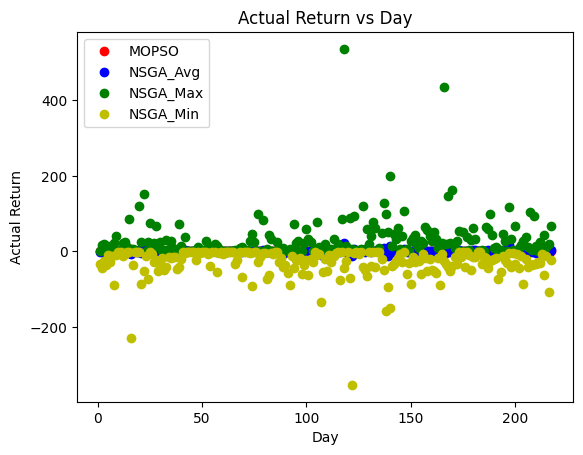

In [33]:
plt.plot(day,return_at_weights_mopso_bilevel,'o',color='r',label='MOPSO')
plt.plot(day,avg_return_at_weights_nsga_bilevel,'o',color='b',label='NSGA_Avg')
plt.plot(day,max_return_at_weights_nsga_bilevel,'o',color='g',label='NSGA_Max')
plt.plot(day,min_return_at_weights_nsga_bilevel,'o',color='y',label='NSGA_Min')
plt.xlabel('Day')
plt.ylabel('Actual Return')
plt.title('Actual Return vs Day')
plt.legend()
plt.show()

In [34]:
print(sum(return_at_weights_mopso_bilevel))
print(sum(avg_return_at_weights_nsga_bilevel))
print(sum(max_return_at_weights_nsga_bilevel))
print(sum(min_return_at_weights_nsga_bilevel))

0.07920428648972805
47.02382186854098
6879.15397860174
-6320.549747839372


In [36]:
sharpe_ratio_mopso = []
skewness_mopso = []
kurtosis_mopso = []
day_primary = []

In [ ]:
expected_return_mopso = []

In [37]:
for i in range(1,total_rows-1):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_cov = np.cov(np.transpose(temp_return_rate))
  
  return_mopso = weights_mopso_bilevel[i-1]@temp_exp_return
  expected_return_mopso.append(return_mopso)

  sr, skew, kurt = calculate_skewness_kurtosis(weights_mopso_bilevel[i-1], temp_price_np)
  sharpe_ratio_mopso.append(sr)
  skewness_mopso.append(skew)
  kurtosis_mopso.append(kurt)

  day_primary.append(i-1)

In [ ]:
# diff_ga = []
diff_mopso = []

for i in range(len(sharpe_ratio_mopso)):
#   diff_ga.append(abs(expected_return_ga[i]-return_at_weights_ga_bilevel[i]))
  diff_mopso.append(abs(expected_return_mopso[i]-return_at_weights_mopso_bilevel[i]))

In [ ]:
print(sum(diff_mopso))
print(sum(diff_min_nsga_bilvel))
print(sum(diff_max_nsga_bilevel))
print(sum(diff_avg_nsga_bilevel))

In [41]:
max_sharpe_ratio_nsga_bilevel = []
min_sharpe_ratio_nsga_bilevel = []
avg_sharpe_ratio_nsga_bilevel = []

max_skewness_nsga_bilevel = []
min_skewness_nsga_bilevel = []
avg_skewness_nsga_bilevel = []

max_kurtosis_nsga_bilevel = []
min_kurtosis_nsga_bilevel = []
avg_kurtosis_nsga_bilevel = []

In [42]:
for i in range(1,total_rows-1):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_cov = np.cov(np.transpose(temp_return_rate))

  max_sharpe_ratio_nsga_bilevel.append(-1e9)
  min_sharpe_ratio_nsga_bilevel.append(1e9)
  avg_sharpe_ratio_nsga_bilevel.append(0)

  max_skewness_nsga_bilevel.append(-1e9)
  min_skewness_nsga_bilevel.append(1e9)
  avg_skewness_nsga_bilevel.append(0)

  max_kurtosis_nsga_bilevel.append(-1e9)
  min_kurtosis_nsga_bilevel.append(1e9)
  avg_kurtosis_nsga_bilevel.append(0)

  for ind in range(len(weights_nsga_bilevel[i-1])):
    sr, skew, kurt = calculate_skewness_kurtosis(weights_nsga_bilevel[i-1][ind], temp_price_np)

    max_sharpe_ratio_nsga_bilevel[i-1] = max(max_sharpe_ratio_nsga_bilevel[i-1], sr)
    min_sharpe_ratio_nsga_bilevel[i-1] = min(min_sharpe_ratio_nsga_bilevel[i-1], sr)
    avg_sharpe_ratio_nsga_bilevel[i-1] = (ind*(avg_sharpe_ratio_nsga_bilevel[i-1]) + sr)/(ind+1)

    max_skewness_nsga_bilevel[i-1] = max(max_skewness_nsga_bilevel[i-1], skew)
    min_skewness_nsga_bilevel[i-1] = min(min_skewness_nsga_bilevel[i-1],skew)
    avg_skewness_nsga_bilevel[i-1] = (ind*(avg_skewness_nsga_bilevel[i-1]) + skew)/(ind+1)

    max_kurtosis_nsga_bilevel[i-1] = max(max_kurtosis_nsga_bilevel[i-1], kurt)
    min_kurtosis_nsga_bilevel[i-1] = min(min_kurtosis_nsga_bilevel[i-1],kurt)
    avg_kurtosis_nsga_bilevel[i-1] = (ind*(avg_kurtosis_nsga_bilevel[i-1]) + kurt)/(ind+1)


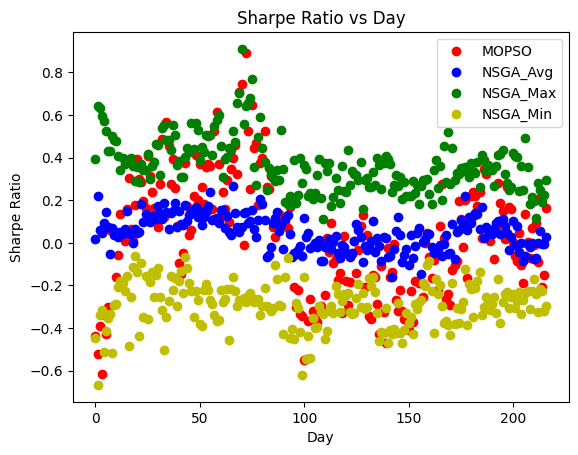

In [45]:
plt.plot(day_primary,sharpe_ratio_mopso,'o',color='r',label='MOPSO')
plt.plot(day_primary,avg_sharpe_ratio_nsga_bilevel,'o',color='b',label='NSGA_Avg')
plt.plot(day_primary,max_sharpe_ratio_nsga_bilevel,'o',color='g',label='NSGA_Max')
plt.plot(day_primary,min_sharpe_ratio_nsga_bilevel,'o',color='y',label='NSGA_Min')
plt.xlabel('Day')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Day')
plt.legend()
plt.show()

In [44]:
print(sum(sharpe_ratio_mopso))
print(sum(avg_sharpe_ratio_nsga_bilevel))
print(sum(max_sharpe_ratio_nsga_bilevel))
print(sum(min_sharpe_ratio_nsga_bilevel))

6.600576468660734
10.341454257616453
79.01761042482586
-62.71533021289617


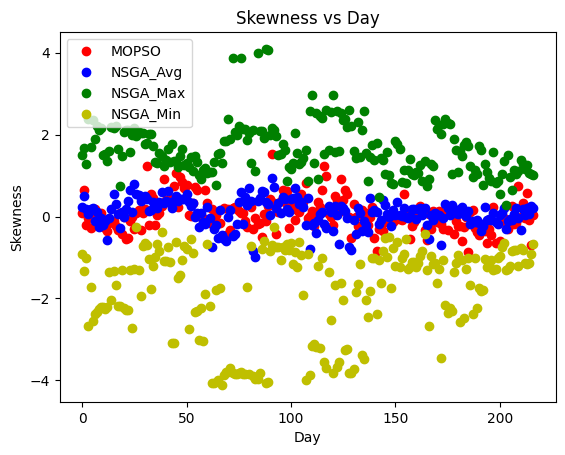

In [46]:
plt.plot(day_primary,skewness_mopso,'o',color='r',label='MOPSO')
plt.plot(day_primary,avg_skewness_nsga_bilevel,'o',color='b',label='NSGA_Avg')
plt.plot(day_primary,max_skewness_nsga_bilevel,'o',color='g',label='NSGA_Max')
plt.plot(day_primary,min_skewness_nsga_bilevel,'o',color='y',label='NSGA_Min')
plt.xlabel('Day')
plt.ylabel('Skewness')
plt.title('Skewness vs Day')
plt.legend()
plt.show()

In [48]:
print(sum(skewness_mopso))
print(sum(avg_skewness_nsga_bilevel))
print(sum(max_skewness_nsga_bilevel))
print(sum(min_skewness_nsga_bilevel))

10.329735650181304
17.544355953324786
353.5512220521087
-395.7241671043889


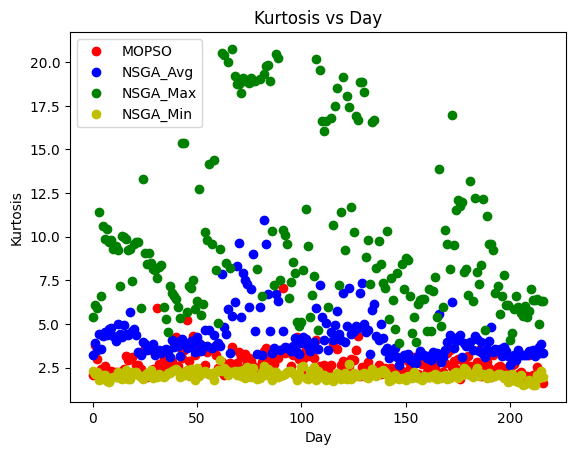

In [47]:
plt.plot(day_primary,kurtosis_mopso,'o',color='r',label='MOPSO')
plt.plot(day_primary,avg_kurtosis_nsga_bilevel,'o',color='b',label='NSGA_Avg')
plt.plot(day_primary,max_kurtosis_nsga_bilevel,'o',color='g',label='NSGA_Max')
plt.plot(day_primary,min_kurtosis_nsga_bilevel,'o',color='y',label='NSGA_Min')
plt.xlabel('Day')
plt.ylabel('Kurtosis')
plt.title('Kurtosis vs Day')
plt.legend()
plt.show()

In [49]:
print(sum(kurtosis_mopso))
print(sum(avg_kurtosis_nsga_bilevel))
print(sum(max_kurtosis_nsga_bilevel))
print(sum(min_kurtosis_nsga_bilevel))

597.7991551867157
919.1608544104665
2163.208715672856
450.53162121821384


In [ ]:
for i in range(num_days-window-2):
  max_return_at_weights_nsga_bilevel.append(-1e9)
  min_return_at_weights_nsga_bilevel.append(1e9)
  avg_return_at_weights_nsga_bilevel.append(0)
  for ind in range(len(returns_nsga_bilevel[i])):
    rog = weights_nsga_bilevel[i][ind]@return_rate[i]
    max_return_at_weights_nsga_bilevel[i] = max(max_return_at_weights_nsga_bilevel[i], rog)
    min_return_at_weights_nsga_bilevel[i] = min(min_return_at_weights_nsga_bilevel[i], rog)
    avg_return_at_weights_nsga_bilevel[i] = (ind*(avg_return_at_weights_nsga_bilevel[i]) + rog)/(ind+1)